# Allegro

In [1]:
import pandas as pd
import category_encoders as ce
import numpy as np
import sklearn 
import random
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import matplotlib
import seaborn as sns
import warnings
from statistics import stdev
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
allegro = pd.read_csv('allegro-api-transactions.csv')

In [3]:
allegro_min = allegro[:10000]

In [4]:
# wybieram dwie kolumny it_location oraz price
location = allegro_min['it_location']
price = allegro_min['price']

# Target Encoding

In [5]:
target_encoder = ce.TargetEncoder() #tworze obiekt TargetEncoder
location_target = target_encoder.fit_transform(location, price) # wykonuje transformacje na kolumnie location
                                                                # wzgldem kolumny price

In [6]:
# wyniki
location_target

,it_location
0,60.738656
1,60.738656
2,127.729583
3,32.121760
4,106.193846
...,...
9995,46.781218
9996,57.636950
9997,57.636950
9998,57.636950


# One Hot Encoding

In [ ]:
# metoda jest w bloku try, ponieważ duza liczba watosci sprawia to ze zostaje przepełniona pamiec przy uruchamianiu
# kodu. Zaraz pokaze równiez liczbe różnych krekordów w koluminie location
try:
    one_hot_enconder = ce.OneHotEncoder()
    location_one = one_hot_enconder.fit_transform(location)
except MemoryError as e:
    print("Za mało pamięci", e)

In [7]:
l1 = len(pd.DataFrame(location)["it_location"].value_counts()) #licze ile jest róznych rekordow
l2 = allegro.shape[0]
print(f"Macierz utowrozna z one hot encoding miała by wymiary: {l1} x {l2}, gdzie {(l2*l1 - l2)/(l1*l2)}% liczb to zera")

Macierz utowrozna z one hot encoding miała by wymiary: 1882 x 420020, gdzie 0.9994686503719448% liczb to zera


# Wnioski
## Target Encoding
* Target Encoding jest szybkim sposobem na zmieniene daych kategorycznych na liczbowe
* Dodatkowo nie daje dodatkowych wymiarów do danych
* Wadą może być to ze taki sposób jest czuły na rozkład danych i ucząc model łatwo można uzyskać overfitting, ponieważ dane w zbiorze testowym moga miec inny rozkłąd niż w treningowym czy walidacyjnym

## One Hot Encoding
* W przypadku duzej liczby róznych danych jest malo wydajny.
* Jest za to łatwijszy w zrozumieniu, bo od razu widać w jaki sposob odbywa sie kodowanie
* Nie jest aż tak podatny na rozklad zbioru danych

# Inne kodowania

# Ordinal Encoding

In [8]:
ordinal_encoder = ce.OrdinalEncoder()
location_ordinal = ordinal_encoder.fit_transform(location, price)

In [9]:
location_ordinal 

,it_location
0,1
1,1
2,2
3,3
4,4
...,...
9995,1882
9996,70
9997,70
9998,70


Jest to chyba najprostszy ze wszytkich sposobów. Metdoa ta patrzy ile jest rónych wyników i każdemu z nich daje liczbe. Mozna w niej ustalic priorytet, choć w tym przypadku nie jest to potrzebne np. Warszawa ma numer 1, ale nie stoi za tym żadna ważna iformacja. To stopniowanie moze być przydantne przy stopniowaniu np. cold - 1, warm - 2, hot - 3. Przy dużej liczbie róznych rekordów tak jak tutaj raczej malo przydatne.

# M-Estimate Encoding

In [10]:
m_estimate_encoder = ce.MEstimateEncoder()
location_m_estimate = m_estimate_encoder.fit_transform(location, price)

In [11]:
location_m_estimate

,it_location
0,60.768113
1,60.768113
2,125.664992
3,38.782465
4,105.441870
...,...
9995,49.364930
9996,57.767076
9997,57.767076
9998,57.767076


Jest to bardzo zblizona metoda do Target Enconding, tylko jest ona uproszczona. Ma ona jeden paramter podczas gdy Target Encoding ma dwa. Z tego powodu, że są to metody bardzo zbliżona ma ona wszytkie zalety Target Enconding. Sprawdznie na danych faktycznie pokazuje, że uzyskane wyniki są bardzo zbliżone

# Uzupełnianie braków

In [12]:
allegro_3 = allegro[["price", "it_seller_rating", "it_quantity"]]
allegro_3

,price,it_seller_rating,it_quantity
0,59.99,50177,997
1,4.90,12428,9288
2,109.90,7389,895
3,18.50,15006,971
4,19.90,32975,950
...,...,...,...
420015,180.00,176,0
420016,14.99,34851,2
420017,5.99,983,470
420018,200.00,163,0


In [14]:
def experiment(n, per, lista, df_allegro, neigh, limit):
    df = df_allegro[:limit]
    stds = []
    m = len(lista)
    k = len(df[lista[0]])
    colname = df.keys()
    for i in range(n):
        cpdf = df.copy(deep=True)
        for j in range(m): # dla kazdej kolmny
            idx = random.sample(list(range(k)), k//per) # wybieram pewene wiersze
            cpdf.loc[idx, lista[j]] = np.nan # uzupełniam nanami
        nearest_neigh = KNNImputer(n_neighbors = neigh,weights = 'uniform') # korszytam z merody nearest neighbours
        transform = pd.DataFrame(nearest_neigh.fit_transform(cpdf))
        transform.columns = colname
        rmse = mean_squared_error(transform[lista], df[lista], squared = False) # obliczam rmse
        stds.append(rmse)
    return np.std(stds), stds

In [29]:
# dla kolumny it_seller_rating liczymy odchylnie standardowe dla 5 najbliższych sasiadów, 10 powtórzeń,
# zbioru allegro_3 z 1000 elemantami i usuwamy 10% zbioru
std_num, stds = experiment(10, 10, ["it_seller_rating"], allegro_3, 5, 1000)

In [27]:
std_num

2013.3518517038353

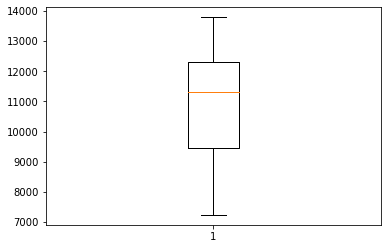

In [28]:
plt.boxplot(stds)
plt.show()

Widzimy ze odchylenie standardowe jest sotsunkowo duze. Mysle ze na podsatwie 2 kolumn price i it_quantity cieko jest precyzyjnie okreslić czy uzyskana wartosci jest satysfakcjonująca. Produkt moze kosztowac malo i byc popluarny, ale mozetez byc tani i cieszyc sie malym zaintersowniem. Taka sama sytuacja moze miec miejsce dla drogich rzeczy. Moga one byc one popularne lub nie. Stad wlasnie moga wynikac zaburzenia 

In [30]:
# dla kolumny it_seller_rating i it_quantity liczymy odchylnie standardowe dla 5 najbliższych sasiadów, 10 powtórzeń,
# zbioru allegro_3 z 1000 elemantami i usuwamy 10% zbioru
std_num, stds = experiment(10, 10, ["it_seller_rating","it_quantity"], allegro_3, 5, 1000)

In [22]:
std_num

1410.3937319753193

W tym przpadku jest podobnie. Wynik jest troche niższy. Być moze kolumna it_seller_rating jest bardziej wiarydna gdy brakujacym wynikiem jest it_quantity, jednak jest tez taka szansa ze w jedenym rekordzie będą braki w obydwu kolumnach. Wówczas szacowine brakujacych rekordów odbywa sie tylko i wyłącznie po kolumnie price. Wydaje mi się ze te braki pwonny być uzupelnianie na wikszej liczbie kolmun, żeby metoda nearest neighbours działała lepiej 

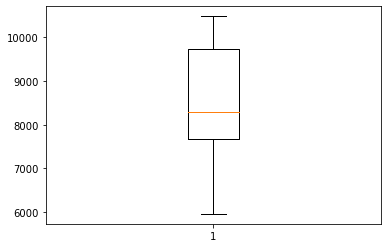

In [24]:
plt.boxplot(stds)
plt.show()